In [51]:
from google.colab import files
uploaded = files.upload()

Saving diabetes_prediction_dataset.csv to diabetes_prediction_dataset (5).csv


Import the necessary libraries

In [52]:
import warnings
warnings.filterwarnings('ignore')

# Import Neccessary libraries
import numpy as np
import pandas as pd

# Import Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#Import Model
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

#Import Sampler libraries
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline

# Set the decimal format
pd.options.display.float_format = "{:.2f}".format

In [53]:


%matplotlib inline

import seaborn as sns



#Import Model

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.preprocessing import  LabelEncoder

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report

from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import SVC

from sklearn.ensemble import GradientBoostingClassifier


In [54]:
df = pd.read_csv('diabetes_prediction_dataset.csv')

In [55]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.00,0,1,never,25.19,6.60,140,0
1,Female,54.00,0,0,No Info,27.32,6.60,80,0
2,Male,28.00,0,0,never,27.32,5.70,158,0
3,Female,36.00,0,0,current,23.45,5.00,155,0
4,Male,76.00,1,1,current,20.14,4.80,155,0


## Lets do some EDA

In [56]:
# Handle duplicates in the data
duplicate_rows_data = df[df.duplicated()]
print("number of duplicate rows: ", duplicate_rows_data.shape)

number of duplicate rows:  (3854, 9)


In [57]:
df = df.drop_duplicates()

In [58]:
# Show distinct values
for column in df.columns:
    num_distinct_values = len(df[column].unique())
    print(f"{column}: {num_distinct_values} distinct values")

gender: 3 distinct values
age: 102 distinct values
hypertension: 2 distinct values
heart_disease: 2 distinct values
smoking_history: 6 distinct values
bmi: 4247 distinct values
HbA1c_level: 18 distinct values
blood_glucose_level: 18 distinct values
diabetes: 2 distinct values


In [59]:
print(df.isnull().sum())

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64


In [60]:
# Remove useless values
df = df[df['gender'] != 'Other']

In [61]:
df.describe().style.format("{:.2f}")

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,96128.00,96128.00,96128.00,96128.00,96128.00,96128.00,96128.00
mean,41.80,0.08,0.04,27.32,5.53,138.22,0.09
std,22.46,0.27,0.20,6.77,1.07,40.91,0.28
min,0.08,0.00,0.00,10.01,3.50,80.00,0.00
25%,24.00,0.00,0.00,23.40,4.80,100.00,0.00
50%,43.00,0.00,0.00,27.32,5.80,140.00,0.00
75%,59.00,0.00,0.00,29.86,6.20,159.00,0.00
max,80.00,1.00,1.00,95.69,9.00,300.00,1.00


## Plot some graphs to have a better picture

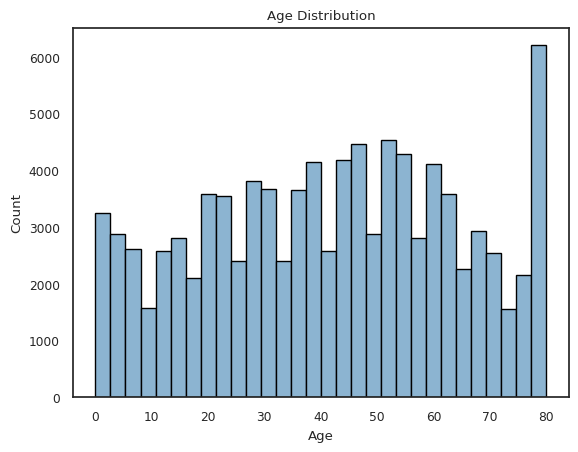

In [62]:
# Histogram for age
plt.hist(df['age'], bins=30, edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

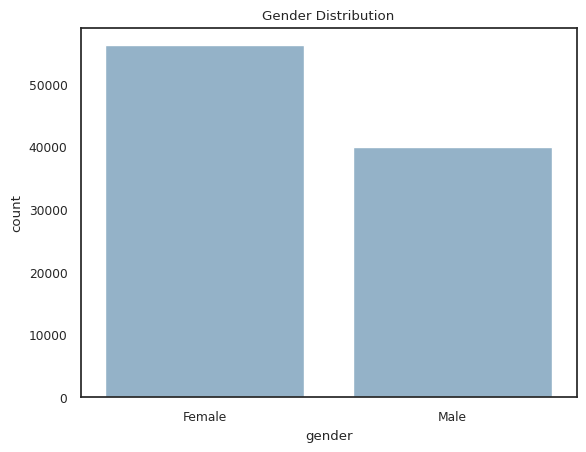

In [63]:
# Bar plot for gender
sns.countplot(x='gender', data=df)
plt.title('Gender Distribution')
plt.show()

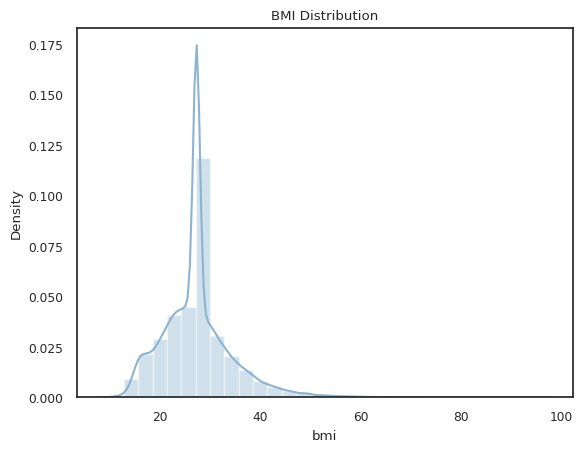

In [64]:
# Distribution plot for BMI
sns.distplot(df['bmi'], bins=30)
plt.title('BMI Distribution')
plt.show()

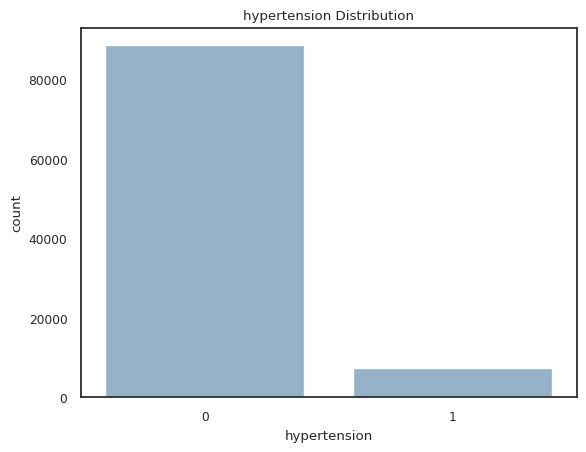

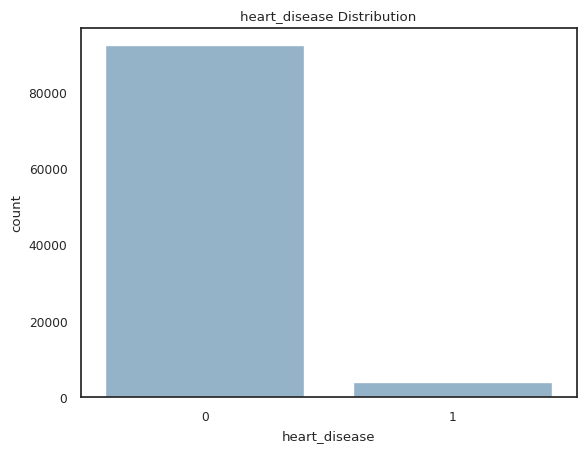

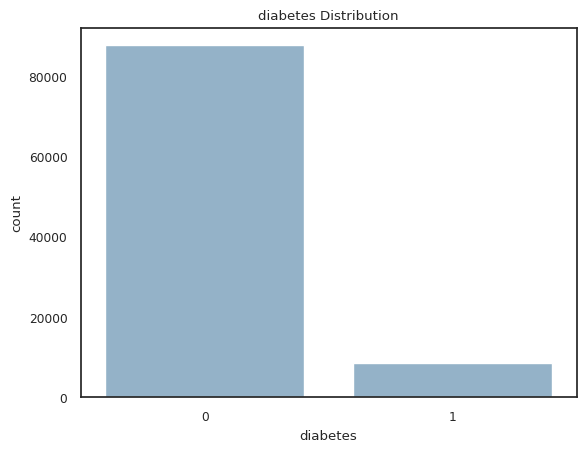

In [65]:
# Count plots for binary variables
for col in ['hypertension', 'heart_disease', 'diabetes']:
    sns.countplot(x=col, data=df)
    plt.title(f'{col} Distribution')
    plt.show()


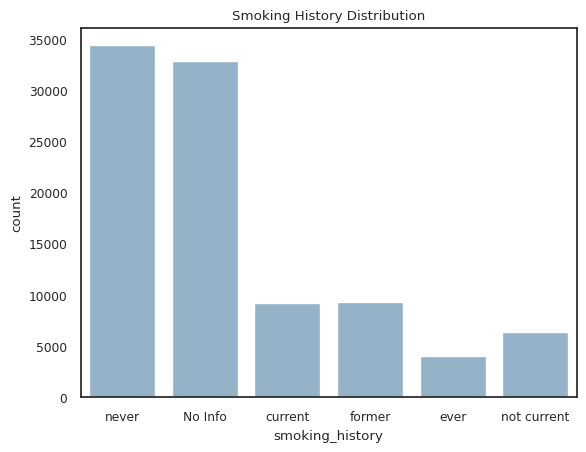

In [66]:
# Count plot for smoking history
sns.countplot(x='smoking_history', data=df)
plt.title('Smoking History Distribution')
plt.show()


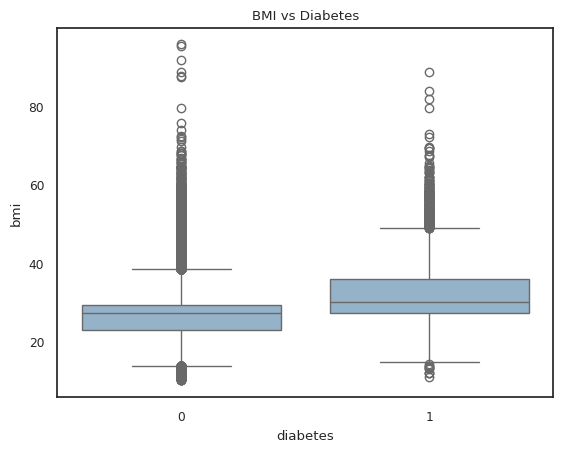

In [67]:
# Boxplot BMI vs Diabetes classification
sns.boxplot(x='diabetes', y='bmi', data=df)
plt.title('BMI vs Diabetes')
plt.show()

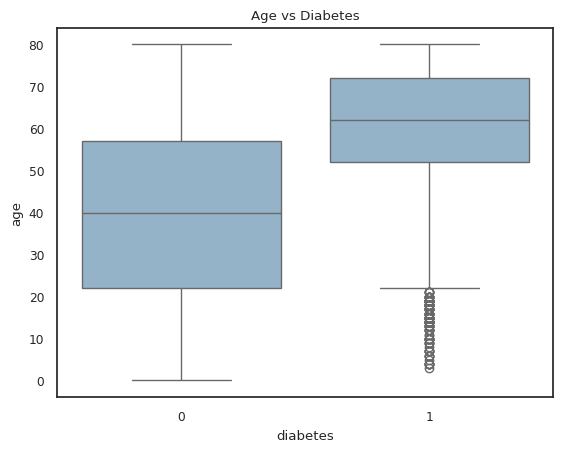

In [68]:
# Boxplot Age vs Diabetes
sns.boxplot(x='diabetes', y='age', data=df)
plt.title('Age vs Diabetes')
plt.show()


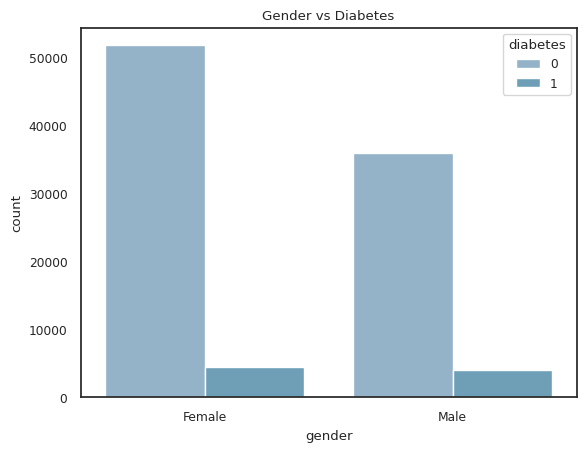

In [69]:
# Count plot of gender vs diabetes
sns.countplot(x='gender', hue='diabetes', data=df)
plt.title('Gender vs Diabetes')
plt.show()

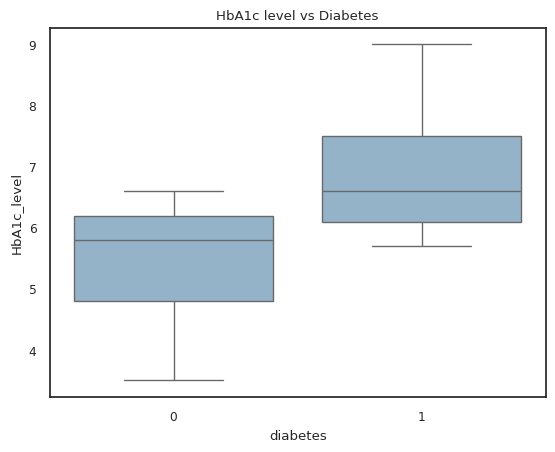

In [70]:
# Boxplot HbA1c level vs Diabetes classification
sns.boxplot(x='diabetes', y='HbA1c_level', data=df)
plt.title('HbA1c level vs Diabetes')
plt.show()

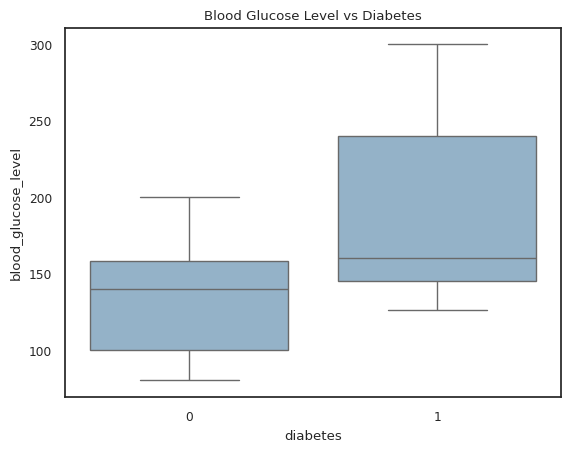

In [71]:
# Boxplot blood glucose level vs Diabetes
sns.boxplot(x='diabetes', y='blood_glucose_level', data=df)
plt.title('Blood Glucose Level vs Diabetes')
plt.show()

###Multivariate Analysis ###

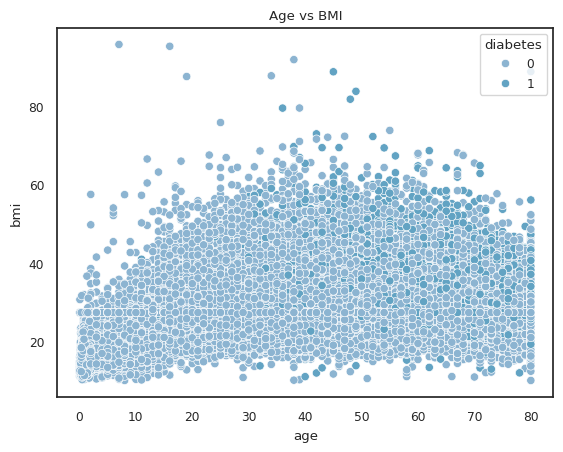

In [73]:
# Scatterplot Age vs BMI colored by Diabetes classification
sns.scatterplot(x='age', y='bmi', hue='diabetes', data=df)
plt.title('Age vs BMI')
plt.show()

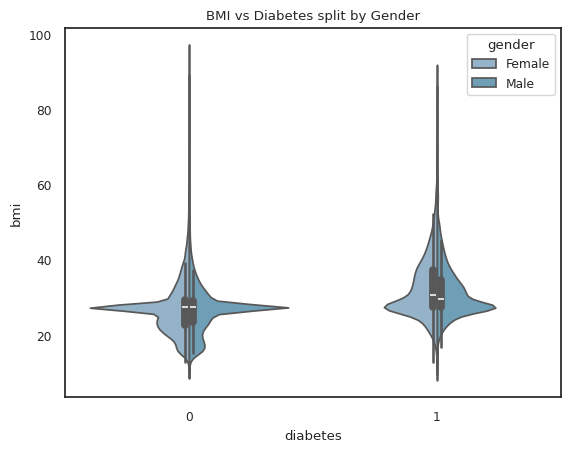

In [74]:
# Violin plot of BMI vs diabetes classification by gender
sns.violinplot(x='diabetes', y='bmi', hue='gender', split=True, data=df)
plt.title('BMI vs Diabetes split by Gender')
plt.show()

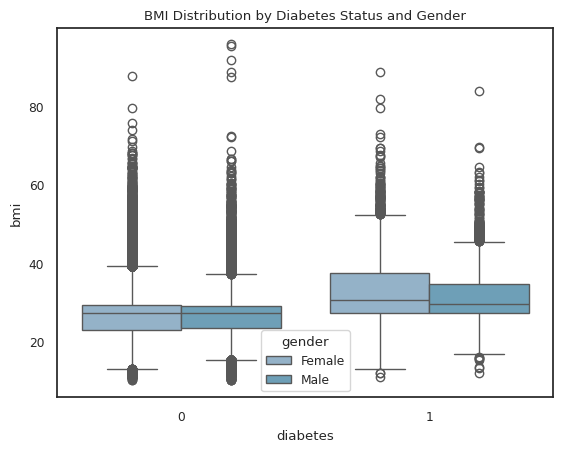

In [75]:
# Interaction between gender, BMI and diabetes
sns.boxplot(x='diabetes', y='bmi', hue='gender', data=df)
plt.title('BMI Distribution by Diabetes Status and Gender')
plt.show()

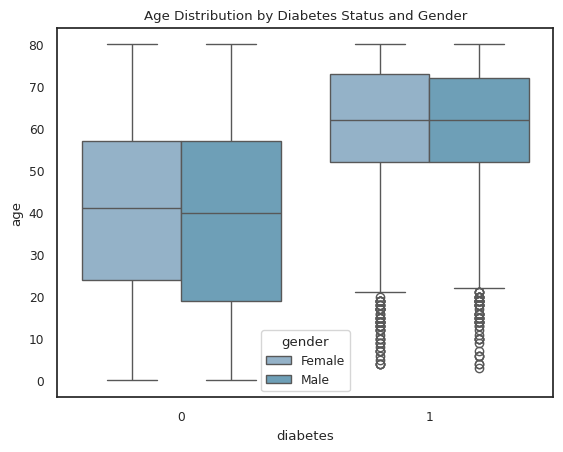

In [76]:
# Interaction between gender, Age and diabetes
sns.boxplot(x='diabetes', y='age', hue='gender', data=df)
plt.title('Age Distribution by Diabetes Status and Gender')
plt.show()

##Correlation

In [77]:
# Function to map the existing categories to new ones
def recategorize_smoking(smoking_status):
    if smoking_status in ['never', 'No Info']:
        return 'non-smoker'
    elif smoking_status == 'current':
        return 'current'
    elif smoking_status in ['ever', 'former', 'not current']:
        return 'past_smoker'

# Apply to the 'smoking_history' column
df['smoking_history'] = df['smoking_history'].apply(recategorize_smoking)

# New value counts
print(df['smoking_history'].value_counts())

smoking_history
non-smoker     67276
past_smoker    19655
current         9197
Name: count, dtype: int64


In [78]:
data = df.copy()

In [79]:
def perform_one_hot_encoding(df, column_name):

    dummies = pd.get_dummies(df[column_name], prefix=column_name)
    df = pd.concat([df.drop(column_name, axis=1), dummies], axis=1)

    return df

# one-hot encoding for gender
data = perform_one_hot_encoding(data, 'gender')

# for smoking history
data = perform_one_hot_encoding(data, 'smoking_history')

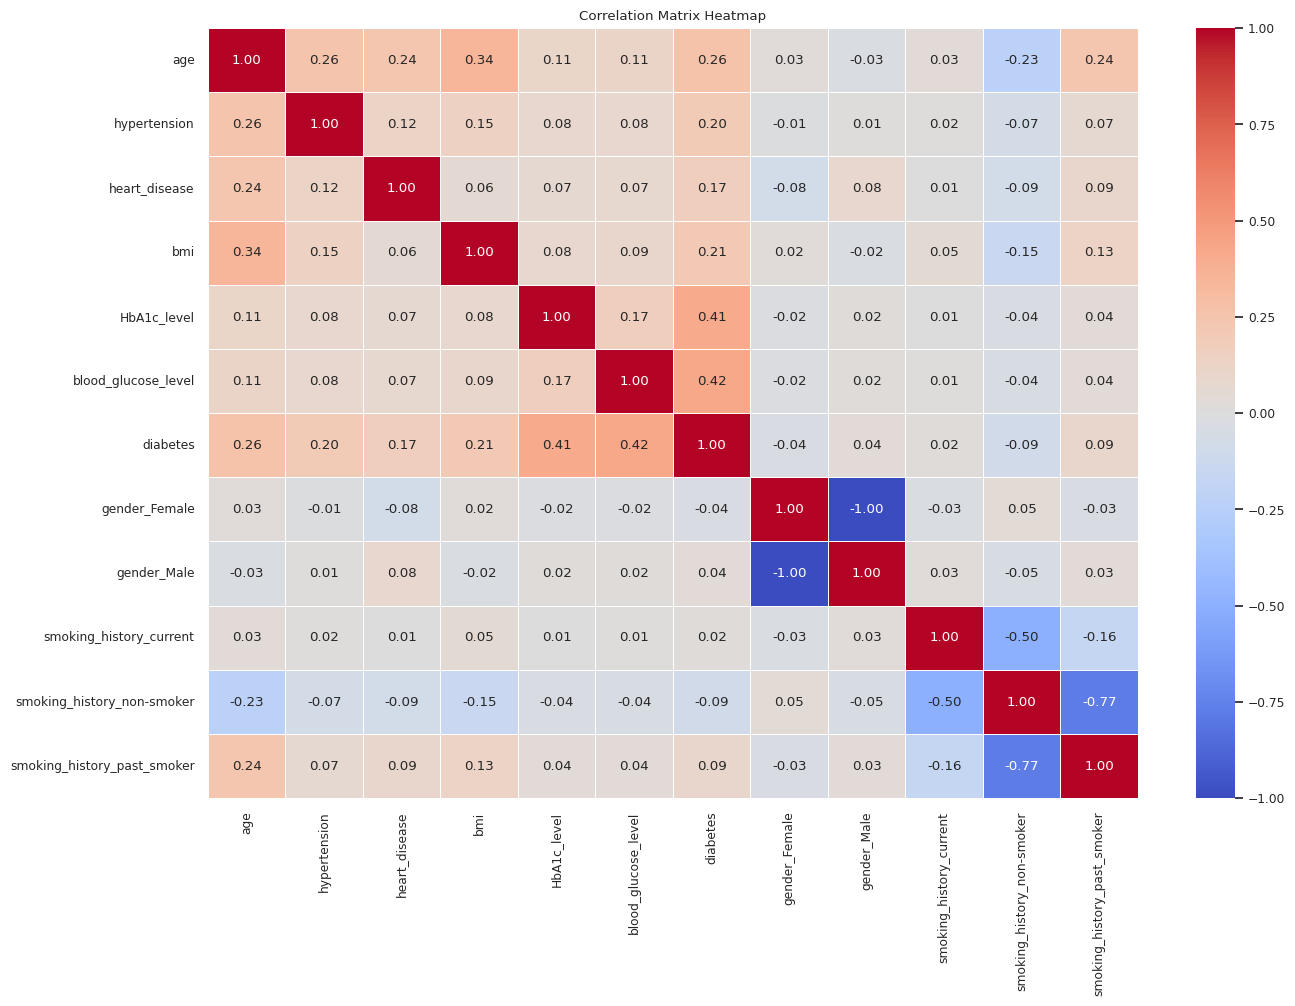

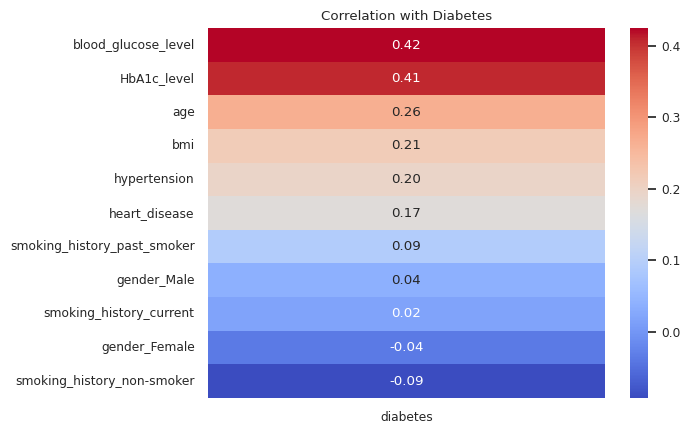

In [80]:
# correlation matrix
correlation_matrix = data.corr()

plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title("Correlation Matrix Heatmap")
plt.show()


# create a heatmap
corr = data.corr()
target_corr = corr['diabetes'].drop('diabetes')

# Sorting correlation values in descending order
target_corr_sorted = target_corr.sort_values(ascending=False)

sns.set(font_scale=0.8)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr_sorted.to_frame(), cmap="coolwarm", annot=True, fmt='.2f')
plt.title('Correlation with Diabetes')
plt.show()



##Handling class imbalance

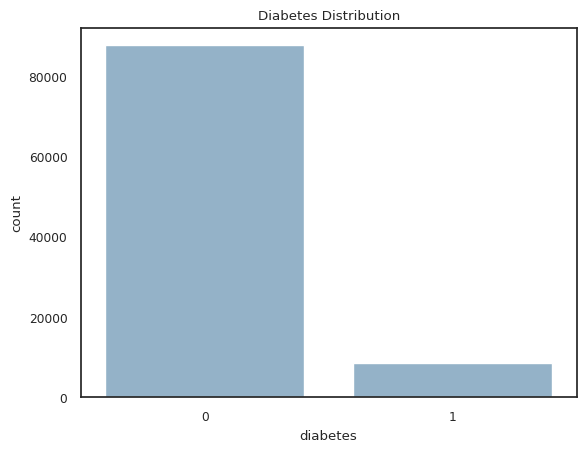

In [81]:
# Count plot for the 'diabetes'
sns.countplot(x='diabetes', data=df)
plt.title('Diabetes Distribution')
plt.show()

In [82]:
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)

###Preprocessing - might have to remove this one

In [83]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level','hypertension','heart_disease']),
        ('cat', OneHotEncoder(), ['gender','smoking_history'])
    ])

# Split data into features and target variable
X = df.drop('diabetes', axis=1)
y = df['diabetes']

In [85]:
#converting categorical data into numerical data

encoder=LabelEncoder()
df['gender']=encoder.fit_transform(df['gender'])
df['smoking_history']=encoder.fit_transform(df['smoking_history'])

##Splitting data

In [86]:
X = df.drop('diabetes', axis=1)
y = df['diabetes']

In [87]:


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size = 0.2)



In [88]:

X_train.shape,X_test.shape,X.shape

((76902, 8), (19226, 8), (96128, 8))

#Logistic Regression model

In [89]:
lr=LogisticRegression(max_iter=3000)
lr.fit(X_train,y_train)
y_predection=lr.predict(X_test)

In [90]:
lr_accuracy = accuracy_score(y_test, y_predection)
lr_conf_matrix = confusion_matrix(y_test, y_predection)
lr_classification_rep = classification_report(y_test, y_predection)

In [91]:
print(f'lr_Accuracy: {lr_accuracy:.2f}')
print('\nlr_Confusion Matrix:')
print(lr_conf_matrix)
print('\nlr_Classification Report:')
print(lr_classification_rep)

lr_Accuracy: 0.96

lr_Confusion Matrix:
[[17351   174]
 [  655  1046]]

lr_Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     17525
           1       0.86      0.61      0.72      1701

    accuracy                           0.96     19226
   macro avg       0.91      0.80      0.85     19226
weighted avg       0.95      0.96      0.95     19226



In [92]:
print("Training Score:",lr.score(X_train,y_train)*100,'%')
print("Testing Score:",lr.score(X_test,y_test)*100,'%')

Training Score: 95.92078229434865 %
Testing Score: 95.68813065640279 %


## Random Forest

In [93]:
# parameter grid to search

param_grid_ = {
    'n_estimators': [10, 50, 300, 200],  # Number of trees
    'max_depth': [None, 10, 20, 30],    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]

}

random_forest_model = GridSearchCV(RandomForestClassifier(), param_grid=param_grid_, cv=2, n_jobs=-1)


In [94]:
random_forest_model = RandomForestClassifier()

random_forest_model.fit(X_train,y_train)

RandomForestClassifier()

In [95]:
y_pred_rf=random_forest_model.predict(X_test)

In [96]:
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_conf_matrix = confusion_matrix(y_test, y_pred_rf)
rf_classification_rep = classification_report(y_test, y_pred_rf)

In [97]:
print(f'rf_Accuracy: {rf_accuracy:.3f}')
print('\nrf_Confusion Matrix:')
print(rf_conf_matrix)
print('\nrf_Classification Report:')
print(rf_classification_rep)

rf_Accuracy: 0.966

rf_Confusion Matrix:
[[17436    89]
 [  563  1138]]

rf_Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     17525
           1       0.93      0.67      0.78      1701

    accuracy                           0.97     19226
   macro avg       0.95      0.83      0.88     19226
weighted avg       0.97      0.97      0.96     19226



In [98]:
print("Training Score:",random_forest_model.score(X_train,y_train)*100,'%')
print("Testing Score:",random_forest_model.score(X_test,y_test)*100,'%')

Training Score: 99.8777665080232 %
Testing Score: 96.60875897222512 %


## SVM

In [101]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Use the same features and target
X = df.drop('diabetes', axis=1)
y = df['diabetes']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

svm_model = SVC(kernel='linear', probability=True, max_iter=3000, random_state=42)
svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)

svm_accuracy = accuracy_score(y_test, y_pred_svm)
svm_conf_matrix = confusion_matrix(y_test, y_pred_svm)
svm_classification_rep = classification_report(y_test, y_pred_svm)

print("Linear SVM Accuracy:", svm_accuracy)
print("Confusion Matrix:\n", svm_conf_matrix)
print("Classification Report:\n", svm_classification_rep)


Linear SVM Accuracy: 0.6240507645896183
Confusion Matrix:
 [[11167  6358]
 [  870   831]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.64      0.76     17525
           1       0.12      0.49      0.19      1701

    accuracy                           0.62     19226
   macro avg       0.52      0.56      0.47     19226
weighted avg       0.86      0.62      0.71     19226



##Ensemble method Soft voting

In [102]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report



#Create soft voting ensemble
ensemble = VotingClassifier(
    estimators=[
        ('lr', lr),
        ('rf', random_forest_model),
        ('svm', svm_model)
    ],
    voting='soft'
)

# Train ensemble
ensemble.fit(X_train, y_train)

# Evaluate
y_pred = ensemble.predict(X_test)
print("Classification Report:\n")
print(classification_report(y_test, y_pred))


Classification Report:

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     17525
           1       1.00      0.59      0.74      1701

    accuracy                           0.96     19226
   macro avg       0.98      0.79      0.86     19226
weighted avg       0.96      0.96      0.96     19226



## SHAP (SHapley Additive exPlanations)

In [103]:
!pip install shap --quiet


In [105]:
import shap

# Choose one model first — like Random Forest
model_to_explain = random_forest_model  # or lr_model or svm_model

# If needed, re-fit on full training data
model_to_explain.fit(X_train, y_train)


RandomForestClassifier()

In [ ]:
explainer = shap.TreeExplainer(model_to_explain)
shap_values = explainer.shap_values(X_test)


In [ ]:
# For LR or SVM
model_to_explain = lr
explainer = shap.KernelExplainer(model_to_explain.predict_proba, X_train[:100])  # subset for speed
shap_values = explainer.shap_values(X_test[:50])  # also subset test set

In [ ]:
#For summary
# it will use feature names from df
shap.summary_plot(shap_values, X_test[:50], feature_names=X.columns)
